# Getting started: Maximum Logit Score on MNIST

This notebook aims at introducing the core features of `oodeel`, including :
* Instantiation of `OODDataset` to load a dataset from `tensorflow_datasets` or `torchvision.datasets` catalog and to organize in-distribution and out-of-distribution data.
* Preparation of a `tf.data.Dataset` or a `torch.DataLoader` ready for scoring and/or training.
* A simple utils to train neural nets (adapted when in-distribution is not a standard dataset, such as a subset of class from a dataset)
* Instantiation of `OODBaseDetector` based on an already trained model, that is used for scoring data.
* Some evaluation metrics to assess the quality of OOD detection.

First, some required imports.

In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
from IPython.display import clear_output

from oodeel.methods import MLS
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.utils.tf_training_tools import train_tf_model
from oodeel.utils.torch_training_tools import train_torch_model

from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

cuda_idx = 0 if torch.cuda.is_available() else None

def plot_hist(scores_in, scores_out, bins, log=False):
    if log:
        minim = np.min([np.min(scores_in), np.min(scores_out)])
        scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        _, bins = np.histogram(np.concatenate([scores_in_, scores_out_]), bins=bins)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.xscale('log')
        plt.xlabel("score (normalized log axis)")
    else:
        logbins=bins
        scores_in_ = scores_in 
        scores_out_ = scores_out
        plt.xlabel("score")
    plt.hist((scores_out_, scores_in_), bins=logbins, color=("blue", "orange"), label=("ood", "id"))
    plt.legend()
    plt.show()

Models are saved at *~/.oodeel/saved_models* and data is supposed to be found
at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST vs Fashion MNIST

* In-distribution data: MNIST 
* Out-of-distribution data: Fashion MNIST

### Load and prepare the datasets

This is performed using the class `OODDataset`. First, load the datasets.

Before loading, choose your backend (tensorflow or torch). You only have to give it as input to `OODDataset` and that's it. The rest of the code will be exactly the same regardless of the library (except for model loading).

When a `str` is given as argument, `OODDataset` will automatically search in the `tensorflow_datasets` or `torchision.datasets` catalogs. Be careful with the `str` you give as input, it has to exactly match the name of the dataset in `tensorflow_datasets` or `torchision.datasets` (and it is case-sensitive). 

<div class="admonition tip">
  <p class="admonition-title">Loading from existing data objects</p>
  <p>
    In this notebook, the datasets are loaded from platforms, but you can also instanciate OODDataset with your own tf.data.Dataset, tf.Tensor, torch.Dataset or np.arrays
  </p>
</div>

> **Warning**
>
>*  We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.
>*  When loading from `tensorflow_datasets` or `torchision.datasets`, do not forget to check which `load_kwargs` to add. It can change for different datasets, even withing a same platform. 

In tensorflow from `tensorflow_datasets` catalog:


In [3]:
backend = "tensorflow"

oods_in = OODDataset(
    'mnist', 
    load_kwargs = {"split": "test"}, 
    backend=backend,
)
oods_out = OODDataset(
    'fashion_mnist', 
    load_kwargs = {"split": "test"}, 
    backend=backend,
)
oods_train = OODDataset(
    'mnist', 
    load_kwargs = {"split": "train"}, 
    backend=backend,
)

clear_output()

In pytorch from `torchision.datasets` catalog::

In [3]:
backend = "torch"

oods_in = OODDataset(
    'MNIST', 
    load_kwargs = {"train": False, "root": data_path, "download": True}, 
    backend=backend,
)
oods_out = OODDataset(
    'FashionMNIST', 
    load_kwargs = {"train": False, "root": data_path, "download": True}, 
    backend=backend,
)
oods_train = OODDataset(
    'MNIST', 
    load_kwargs = {"train": True, "root": data_path, "download": True}, 
    backend=backend,
)

> **Note**
>
> When backend is "torch", the datasets can still be loaded from `tensorflow_datasets`, and are converted on the fly and loaded on VRAM as torch tensors. This feature can be useful because tensorflow_datasets's catalog is way larger than torchvision dataset's. In that case, however, the loaded dataset cannot be used for training with `train_torch_model`.

Then, prepare the dataset for scoring and/or training using `.prepare` method.

In [4]:
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128

ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

`ds_in`, `ds_out` and `ds_train` are regular `tf.data.Dataset`or `torch.DataLoader` that you can use like usual!  

Train or load a model on in-distribution data (MNIST).

... a keras model ...

In [6]:
model_path_mnist = os.path.join(model_path, "mnist_model_tensorflow.h5")

try:
    model_tf = tf.keras.models.load_model(model_path_mnist)
except OSError:
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model_tf = train_tf_model(ds_train, **train_config) 

Epoch 1/5
469/469 [==============================] - 14s 21ms/step - loss: 0.3258 - accuracy: 0.9042 - val_loss: 0.0810 - val_accuracy: 0.9754
Epoch 2/5
469/469 [==============================] - 9s 19ms/step - loss: 0.1007 - accuracy: 0.9696 - val_loss: 0.0602 - val_accuracy: 0.9806
Epoch 3/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0782 - accuracy: 0.9758 - val_loss: 0.0436 - val_accuracy: 0.9855
Epoch 4/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0641 - accuracy: 0.9805 - val_loss: 0.0386 - val_accuracy: 0.9876
Epoch 5/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0571 - accuracy: 0.9822 - val_loss: 0.0379 - val_accuracy: 0.9872


... or a pytorch one, if `backend="torch"`

In [5]:
model_path_mnist = os.path.join(model_path, "mnist_model_torch")
try:
    model_torch = torch.load(os.path.join(model_path_mnist, "best.pt"))
except OSError:
    train_config = {
        "model": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in, #ds_in is actually the test set of MNIST
        "cuda_idx": cuda_idx
    }
    model_torch = train_torch_model(ds_train,  **train_config)

Epoch 5/5 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.80it/s, Loss=0.034, Acc=0.989]


### Maximum Logit Score (MLS)

Return an OOD score based on the maximum value of the output logits. Introduced in [Open-Set Recognition: a Good Closed-Set Classifier is All You Need?](http://arxiv.org/abs/2110.06207), ICLR 2022.

In this section, we use `model_tf` because `backend="tensorflow"`

In [6]:
if backend == "tensorflow":
    model = model_tf
elif backend == "torch":
    model = model_torch

Simply fit the `OODBaseDetector` to the model and then score the dataset.

In [7]:
mls = MLS()

mls.fit(model)
scores_in = mls.score(ds_in)
scores_out = mls.score(ds_out)

Compute the evaluation metrics based on the scores of the test data, and visualize the scores histogram.

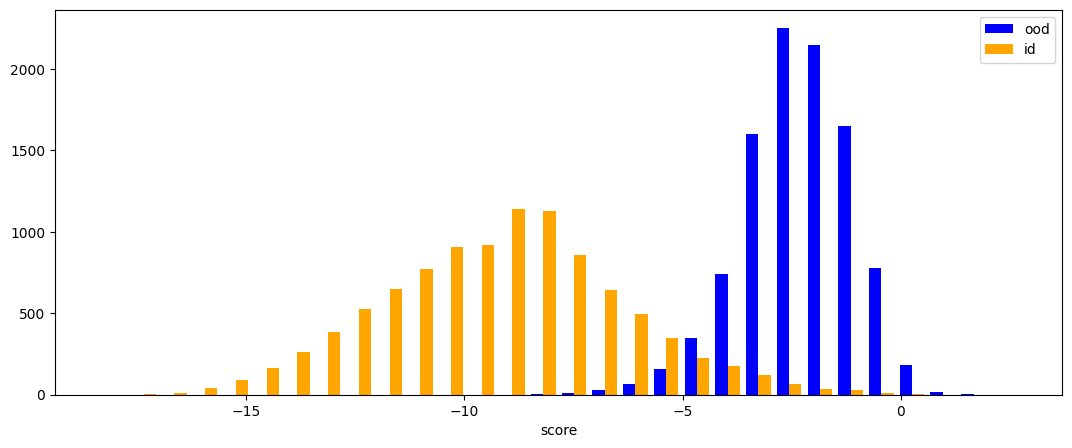

auroc             0.985419
fpr95tpr          0.048100
accuracy_score    0.870900
dtype: float64


In [8]:
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score], 
    threshold = -7.5 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics = pd.Series(metrics)
print(metrics)


### Maximum Softmax Probability (MSP)

It is possible to do the same after the softmax activation. Introduced in [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](http://arxiv.org/abs/1610.02136), ICLR 2017.

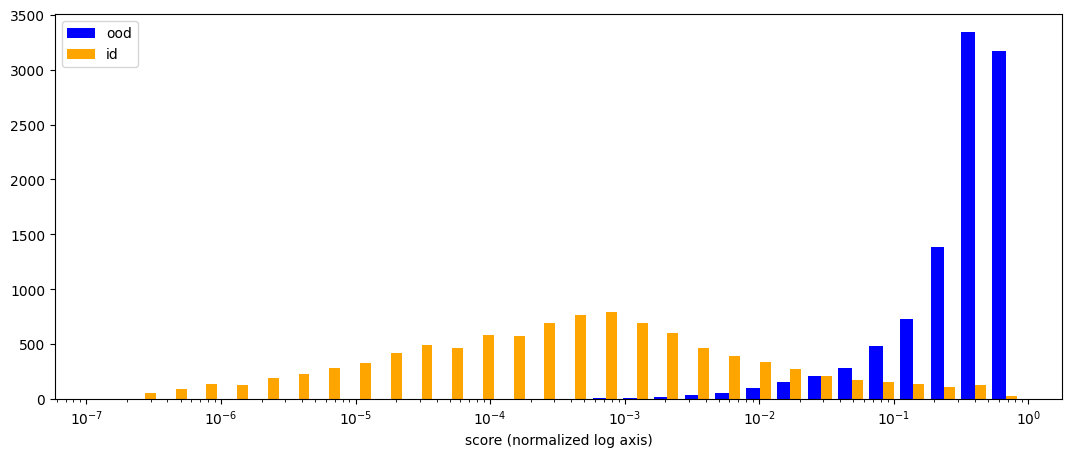

auroc             0.979865
fpr95tpr          0.081700
accuracy_score    0.930650
roc_auc_score     0.979865
dtype: float64


In [9]:
msp = MLS(output_activation="softmax")
msp.fit(model)
scores_in = msp.score(ds_in)
scores_out = msp.score(ds_out)

metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True)
metrics = pd.Series(metrics)
print(metrics)

## MNIST (0-4) vs MNIST (5-9)

* In-distribution data: MNIST (0-4)
* Out-of-distribution data: MNIST (5-9)

We can repeat the procedure in an open-set-recognition or semantic OOD setting by considering a subset of MNIST classes as in-distribution and another subset as out-of-distribution. The datasets are constructed using the `OODDataset` method `.assign_ood_labels_by_class`. First load and split the dataset.

In Tensorflow:

In [5]:
backend = "tensorflow"

oods_test = OODDataset(
    'mnist', 
    load_kwargs = {"split": "test"}, 
    backend=backend,
)
oods_train = OODDataset(
    'mnist', 
    load_kwargs = {"split": "train"}, 
    backend=backend,
)

clear_output()

or in Pytorch

In [ ]:
backend = "torch"

oods_test = OODDataset(
    'MNIST', 
    load_kwargs = {"train": False, "root": data_path, "download": True}, 
    backend=backend,
)
oods_train = OODDataset(
    'MNIST', 
    load_kwargs = {"train": True, "root": data_path, "download": True}, 
    backend=backend,
)

Then prepare the datasets for scoring and/or training.

In [6]:
batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_train, _ = oods_train.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)


Train or load the model.

In Tensorflow:

In [7]:
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    model_tf = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 5,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model_tf = train_tf_model(ds_train, **train_config) 

Epoch 1/5
240/240 [==============================] - 8s 23ms/step - loss: 0.2218 - accuracy: 0.9347 - val_loss: 0.0338 - val_accuracy: 0.9899
Epoch 2/5
240/240 [==============================] - 4s 18ms/step - loss: 0.0533 - accuracy: 0.9838 - val_loss: 0.0188 - val_accuracy: 0.9947
Epoch 3/5
240/240 [==============================] - 5s 19ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.0189 - val_accuracy: 0.9949
Epoch 4/5
240/240 [==============================] - 5s 19ms/step - loss: 0.0312 - accuracy: 0.9899 - val_loss: 0.0147 - val_accuracy: 0.9946
Epoch 5/5
240/240 [==============================] - 5s 19ms/step - loss: 0.0307 - accuracy: 0.9909 - val_loss: 0.0135 - val_accuracy: 0.9955


In Pytorch:

In [10]:
model_path_mnist = os.path.join(model_path, "mnist_model_torch_0-4")
try:
    model_torch = torch.load(os.path.join(model_path_mnist, "best.pt"))
except OSError:
    train_config = {
        "model": "toy_convnet",
        "num_classes": 5,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in, #ds_in is actually the test set of MNIST
        "cuda_idx": cuda_idx
    }
    model_torch = train_torch_model(ds_train,  **train_config)

Epoch 5/5 [Val]: 100%|██████████| 79/79 [00:00<00:00, 878.71it/s, Loss=0.048, Acc=0.984]


### Maximum Logit Score (MLS)

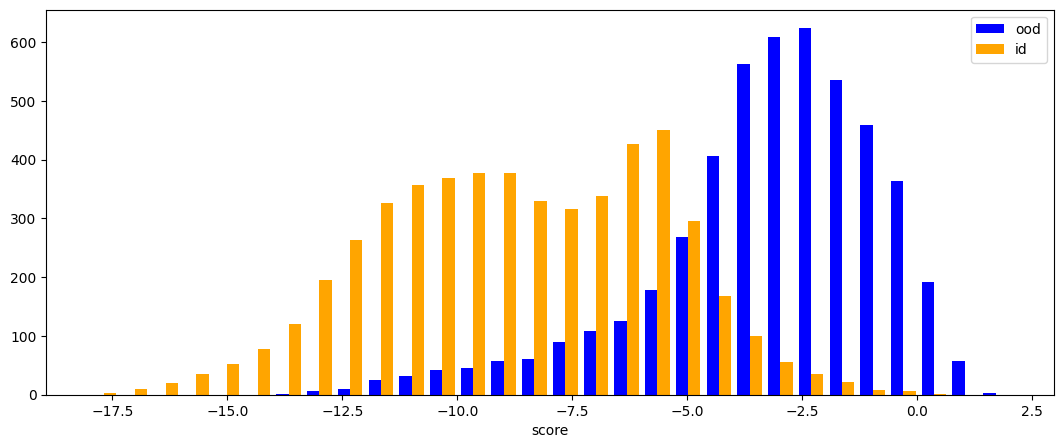

auroc             0.916672
fpr95tpr          0.479082
accuracy_score    0.766200
roc_auc_score     0.916672
dtype: float64


In [11]:
if backend == "tensorflow":
    model = model_tf
elif backend == "torch":
    model = model_torch
    
mls = MLS()
mls.fit(model)
scores_in = mls.score(ds_in)
scores_out = mls.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -7.5 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics = pd.Series(metrics)
print(metrics)

### Maximum Softmax Probability (MSP)

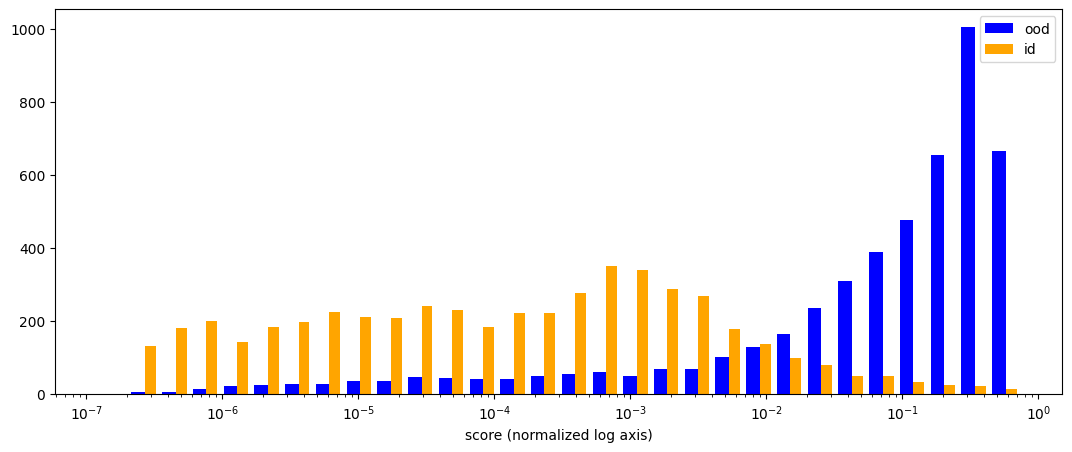

auroc             0.908921
fpr95tpr          0.606927
accuracy_score    0.821500
roc_auc_score     0.908921
dtype: float64


In [12]:
msp = MLS(output_activation="softmax")
msp.fit(model)
scores_in = msp.score(ds_in)
scores_out = msp.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True)
metrics = pd.Series(metrics)
print(metrics)